In [1]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp
from meep import mpb

# Other utilities
import time
from IPython.utils import io

/home/rain/anaconda3/envs/ece558/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/rain/anaconda3/envs/ece558/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/rain/anaconda3/envs/ece558/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/rain/anaconda3/envs/ece558/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Working in 3 dimensions.
Grid size is 1 x 128 x 128.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 4, 0)
     (0, 0, 4)
Cell volume = 16
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.25, -0)
     (0, -0, 0.25)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,0.175,0.15)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 1 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
epsilon: 2.4087-12.0647, mean 2.42455, harm. mean 2.41241, 100% > 1, 0.164063% "fill"


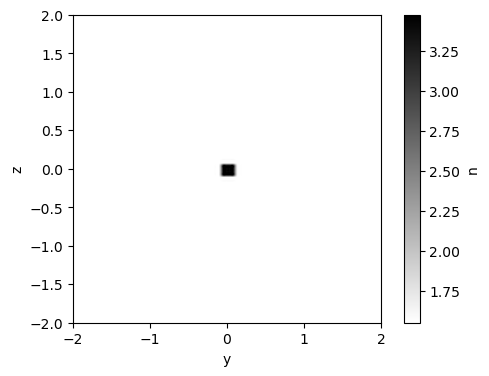

In [4]:
# 1.   Compute the Effective Index Difference of Two Photochromic States in a fully cladded STRIP Waveguide
# 1.1. Photochromic State 1

# Simulation parameters
sc_y = 4 # supercell width (um)
sc_z = 4 # supercell height (um)
resolution = 32 # simulation resolution (pixels/um)
geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z))

# Waveguide definition
wl = 1.55 # args.wl # wavelength (um)
h = 0.150  # Si height (um) # 150 nm as in Bilodeau paper
w = 0.175 # waveguide width (um) # 175 nm as in Bilodeau paper 
Si = mp.Medium(index=3.47343) # Silicon index @ 1550 nm
PC1 = mp.Medium(index=1.552) # Photochromic State 1 index
geometry = [mp.Block(size=mp.Vector3(mp.inf, w, h), center=mp.Vector3(), material=Si)]

ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    resolution=resolution,
    default_material=PC1) # PC is fully covering the waveguide.
ms.init_params(mp.NO_PARITY, True)


# Waveguide Geometry Visualization
fig, ax = plt.subplots(figsize=(6, 4))

n = np.sqrt(ms.get_epsilon())

pos = ax.imshow(n.T, cmap='gray_r', interpolation='spline36', extent=[-sc_y/2,sc_y/2,-sc_z/2,sc_z/2] )
cbar = fig.colorbar(pos, ax=ax)
cbar.set_label('n')
ax.set_xlabel('y')
ax.set_ylabel('z')
plt.show()

In [4]:
# Definition of the formula for effective index of a fully cladded STRIP waveguide

def neff_strip(N=1, w=0.5, wl=1.55, h=0.22, wg=3.47343, cd=1.552, sc_y=4, sc_z=4, res=64):
    '''
    Author:        Simon Bilodeau
    Date:          2021-02-07
    Title:         Silicon photonic strip waveguide simulation
    Script returning the first n effective indices of a silicon photonic strip waveguide
    Accounts for material dispersion of the silicon using a Lorentz model
    
    w (float) : width of the waveguide (microns)
    h (float) : heigth of the waveguide (microns)
    wg (float) : refractive index of the waveguide
    cd (float) : refractive index of the cladding
    wl (float) : wavelength of the simulation (microns)
    n (int) : number of modes to return                                                   
    sc_y (float) : width of the simulation (microns)
    sc_z (float) : heigth of the simulation (microns)
    res (int) : resolution of the simulation (pixels/micron)
    '''
    # Simulation parameters
    geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z))

    # Waveguide definition
    wgm = mp.Medium(index=wg) # index of the waveguide material
    cdm = mp.Medium(index=cd) # index of the cladding material
    geometry = [mp.Block(size=mp.Vector3(mp.inf, w, h), center=mp.Vector3(), material=wgm)]

    # Inverse simulation parameters
    f_mode = 1/wl   # frequency corresponding to desired wavelength (in um) 
    band_min = 1 
    band_max = N
    kdir = mp.Vector3(1) # Our waveguide is along the x direction
    tol = 1e-6 # Iterative solver stop condition
    kmag_guess = f_mode*3.45 # Initial guess
    kmag_min = f_mode*0.1; kmag_max = f_mode*4.0 # Some search range

    # ModeSolver object
    # Some of these are superfluous since we never actually run the forward simulation (e.g. k_points)
    ms = mpb.ModeSolver(
        geometry_lattice=geometry_lattice, # Give it simulation domain
        geometry=geometry, # Give it geometry to simulate
        resolution=res, # Give it discretization level
        default_material=cdm # Fully cladded by photochromic
        )

    # Do the simulation
    k_fmode = ms.find_k(mp.NO_PARITY, f_mode, band_min, band_max, kdir, tol, kmag_guess,
              kmag_min, kmag_max)

    # Compute effective index
    ns_to_return = []
    for i in range(N):
        ns_to_return.append(k_fmode[i] / f_mode)
    
    return ns_to_return

In [22]:
# Calculation of the effective indeices for the first four (N = 4) modes,
# and they are corresponding to TE0, TM0, TE1, and TM1 respectively, from the first to the fourth mode.
# System: strip Si waveguide (n=3.47343) fully cladded by state 1 photochromic (n=1.552)

neffs_strip_list_Si_PC1 = []

with io.capture_output() as captured:
    current_neff = neff_strip(N=4, w=0.175, wl=1.55, h=0.150, wg=3.47343, cd=1.552, sc_y=3, sc_z=3, res=32)
print('w = {0}, neffs = {1}'.format(w, current_neff))
neffs_strip_list_Si_PC1.append([w, current_neff])

w = 0.175, neffs = [1.5316107519809667, 1.5272954190408579, 1.4563801627032285, 1.448162026346958]


In [23]:
# 1.2. Photochromic State 2

# Calculation of the effective indeices for the first four (N = 4) modes,
# and they are corresponding to TE0, TM0, TE1, and TM1 respectively, from the first to the fourth mode.
# System: strip Si waveguide (n=3.47343) fully cladded by state 2 photochromic (n=1.598)

neffs_strip_list_Si_PC2 = []

with io.capture_output() as captured:
    current_neff = neff_strip(N=4, w=0.175, wl=1.55, h=0.150, wg=3.47343, cd=1.598, sc_y=3, sc_z=3, res=32)
print('w = {0}, neffs = {1}'.format(w, current_neff))
neffs_strip_list_Si_PC2.append([w, current_neff])

w = 0.175, neffs = [1.572241943393602, 1.566944952913445, 1.497160848822211, 1.4883705532502287]


Working in 3 dimensions.
Grid size is 1 x 128 x 128.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 4, 0)
     (0, 0, 4)
Cell volume = 16
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.25, -0)
     (0, -0, 0.25)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,0.175,0.15)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,1.0375)
          size (1e+20,1e+20,1.925)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 2 and 8 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
epsilon: 2.08514-12.0647, mean 2.26891, harm. mean 2.24468, 100% > 1, 1.84146% "fill"


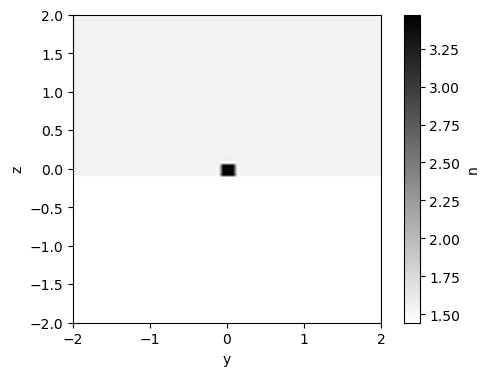

In [9]:
# 2.   Compute the Effective Index Difference of Two Photochromic States 
#        in a STRIP Waveguide Top-Cladded by Photochromic and Bottom-Cladded by SiO2

# Simulation parameters
sc_y = 4 # supercell width (um)
sc_z = 4 # supercell height (um)
resolution = 32 # simulation resolution (pixels/um)
geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z))

# Waveguide definition
wl = 1.55 # args.wl # wavelength (um)
h = 0.150  # Si height (um) # 150 nm as in Bilodeau paper
w = 0.175 # waveguide width (um) # 175 nm as in Bilodeau paper 
Si = mp.Medium(index=3.47343) # Silicon index @ 1550 nm
PC1 = mp.Medium(index=1.552) # Photochromic State 1 index
SiO2 = mp.Medium(index=1.444) # SiO2 bottom cladding index
geometry = [mp.Block(size=mp.Vector3(mp.inf, w, h),center=mp.Vector3(), material=Si),
            mp.Block(size=mp.Vector3(mp.inf, mp.inf, 0.5*sc_z-0.5*h),center=mp.Vector3(0,0,0.25*sc_z+0.25*h), material=SiO2)]

ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    resolution=resolution,
    default_material=PC1) # PC is fully covering the waveguide.
ms.init_params(mp.NO_PARITY, True)


# Waveguide Geometry Visualization
fig, ax = plt.subplots(figsize=(6, 4))

n = np.sqrt(ms.get_epsilon())

pos = ax.imshow(n.T, cmap='gray_r', interpolation='spline36', extent=[-sc_y/2,sc_y/2,-sc_z/2,sc_z/2] )
cbar = fig.colorbar(pos, ax=ax)
cbar.set_label('n')
ax.set_xlabel('y')
ax.set_ylabel('z')
plt.show()

In [12]:
# Definition of the formula for effective index of a STRIP waveguide top-cladded by photochromic and bottom-cladded by SiO2

def neff_strip_SiO2(N=1, w=0.5, wl=1.55, h=0.22, wg=3.47343, cd=1.552, sc_y=4, sc_z=4, res=64):
    '''
    Author:        Simon Bilodeau
    Date:          2021-02-07
    Title:         Silicon photonic strip waveguide simulation
    Script returning the first n effective indices of a silicon photonic strip waveguide
    Accounts for material dispersion of the silicon using a Lorentz model
    
    w (float) : width of the waveguide (microns)
    h (float) : heigth of the waveguide (microns)
    wg (float) : refractive index of the waveguide
    cd (float) : refractive index of the top-cladding
    wl (float) : wavelength of the simulation (microns)
    n (int) : number of modes to return                                                    
    sc_y (float) : width of the simulation (microns)
    sc_z (float) : heigth of the simulation (microns)
    res (int) : resolution of the simulation (pixels/micron)
    '''
    # Simulation parameters
    geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z))

    # Waveguide definition
    SiO2 = mp.Medium(index=1.444) # SiO2 bottom cladding index
    wgm = mp.Medium(index=wg) # index of the waveguide material
    cdm = mp.Medium(index=cd) # index of the cladding material
    geometry = [mp.Block(size=mp.Vector3(mp.inf, w, h),center=mp.Vector3(), material=wgm),
                mp.Block(size=mp.Vector3(mp.inf, mp.inf, 0.5*sc_z-0.5*h),center=mp.Vector3(0,0,0.25*sc_z+0.25*h), material=SiO2)]

    # Inverse simulation parameters
    f_mode = 1/wl   # frequency corresponding to desired wavelength (in um) 
    band_min = 1 
    band_max = N
    kdir = mp.Vector3(1) # Our waveguide is along the x direction
    tol = 1e-6 # Iterative solver stop condition
    kmag_guess = f_mode*3.45 # Initial guess
    kmag_min = f_mode*0.1; kmag_max = f_mode*4.0 # Some search range

    # ModeSolver object
    # Some of these are superfluous since we never actually run the forward simulation (e.g. k_points)
    ms = mpb.ModeSolver(
        geometry_lattice=geometry_lattice, # Give it simulation domain
        geometry=geometry, # Give it geometry to simulate
        resolution=res, # Give it discretization level
        default_material=cdm # Top-cladded by Photochromic
        )

    # Do the simulation
    k_fmode = ms.find_k(mp.NO_PARITY, f_mode, band_min, band_max, kdir, tol, kmag_guess,
              kmag_min, kmag_max)

    # Compute effective index
    ns_to_return = []
    for i in range(N):
        ns_to_return.append(k_fmode[i] / f_mode)
    
    return ns_to_return

In [24]:
# Calculation of the effective indeices for the first four (N = 4) modes,
# and they are corresponding to TE0, TM0, TE1, and TM1 respectively, from the first to the fourth mode.
# System: strip Si waveguide (n=3.47343) top cladded by state 1 photochromic (n=1.552), bottom cladded by SiO2

neffs_strip_list_Si_PC1_SiO2 = []

with io.capture_output() as captured:
    current_neff = neff_strip_SiO2(N=4, w=0.175, wl=1.55, h=0.150, wg=3.47343, cd=1.552, sc_y=3, sc_z=3, res=32)
print('w = {0}, neffs = {1}'.format(w, current_neff))
neffs_strip_list_Si_PC1_SiO2.append([w, current_neff])

w = 0.175, neffs = [1.5316107307697047, 1.527295410863475, 1.4563801388839752, 1.4481620263469572]


In [29]:
# Calculation of the effective indeices for the first four (N = 4) modes,
# and they are corresponding to TE0, TM0, TE1, and TM1 respectively, from the first to the fourth mode.
# System: strip Si waveguide (n=3.47343) top-cladded by state 2 photochromic (n=1.598), bottom-cladded by SiO2

neffs_strip_list_Si_PC2_SiO2 = []

with io.capture_output() as captured:
    current_neff = neff_strip_SiO2(N=4, w=0.175, wl=1.55, h=0.150, wg=3.47343, cd=1.598, sc_y=3, sc_z=3, res=32)
print('w = {0}, neffs = {1}'.format(w, current_neff))
neffs_strip_list_Si_PC2_SiO2.append([w, current_neff])

w = 0.175, neffs = [1.5722418512171517, 1.5669449196252105, 1.4971610478858488, 1.4883705688941704]


Working in 3 dimensions.
Grid size is 1 x 128 x 128.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 4, 0)
     (0, 0, 4)
Cell volume = 16
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.25, -0)
     (0, -0, 0.25)
Geometric objects:
     block, center = (0,0.1275,0)
          size (1e+20,0.175,0.15)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-0.1275,0)
          size (1e+20,0.175,0.15)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,1.0375)
          size (1e+20,1e+20,1.925)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 2 and 10 object nodes (vs. 3 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
epsilon: 2.08514-12.0647, mean 2.28483, harm. mean 2.24791, 100% > 1, 2.00099% "fill"


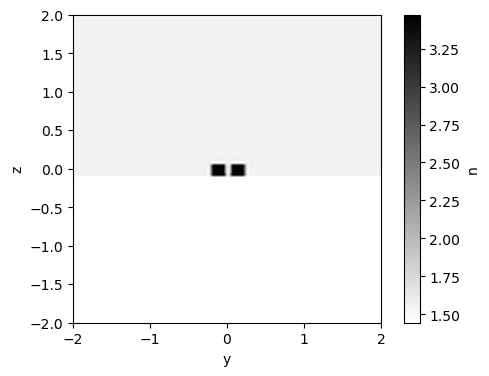

In [31]:
# 3.   Compute the Effective Index Difference of Two Photochromic States 
#        in a SLOT Waveguide Top-Cladded by Photochromic and Bottom-Cladded by SiO2

# Simulation parameters
sc_y = 4 # supercell width (um)
sc_z = 4 # supercell height (um)
resolution = 32 # simulation resolution (pixels/um)
geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z))

# Waveguide definition
wl = 1.55 # args.wl # wavelength (um)
h = 0.150  # Si height (um) # 150 nm as in Bilodeau paper
w = 0.175 # waveguide width (um) # 175 nm as in Bilodeau paper 
ws = 0.08 # slot width (um) # 80 nm as in Bilodeau paper
Si = mp.Medium(index=3.47343) # Silicon index @ 1550 nm
PC1 = mp.Medium(index=1.552) # Photochromic State 1 index
SiO2 = mp.Medium(index=1.444) # SiO2 bottom cladding index
geometry = [mp.Block(size=mp.Vector3(mp.inf, w, h),center=mp.Vector3(0,0.5*w+0.5*ws,0), material=Si),
            mp.Block(size=mp.Vector3(mp.inf, w, h),center=mp.Vector3(0,-0.5*w-0.5*ws,0), material=Si),
            mp.Block(size=mp.Vector3(mp.inf, mp.inf, 0.5*sc_z-0.5*h),center=mp.Vector3(0,0,0.25*sc_z+0.25*h), material=SiO2)]

ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    resolution=resolution,
    default_material=PC1) # PC is fully covering the waveguide.
ms.init_params(mp.NO_PARITY, True)


# Waveguide Geometry Visualization
fig, ax = plt.subplots(figsize=(6, 4))

n = np.sqrt(ms.get_epsilon())

pos = ax.imshow(n.T, cmap='gray_r', interpolation='spline36', extent=[-sc_y/2,sc_y/2,-sc_z/2,sc_z/2] )
cbar = fig.colorbar(pos, ax=ax)
cbar.set_label('n')
ax.set_xlabel('y')
ax.set_ylabel('z')
plt.show()

In [32]:
# Definition of the formula for effective index of a STRIP waveguide top-cladded by photochromic and bottom-cladded by SiO2

def neff_slot_SiO2(N=1, w=0.5, wl=1.55, h=0.22, ws=0.08, wg=3.47343, cd=1.552, sc_y=4, sc_z=4, res=64):
    '''
    Author:        Simon Bilodeau
    Date:          2021-02-07
    Title:         Silicon photonic strip waveguide simulation
    Script returning the first n effective indices of a silicon photonic strip waveguide
    Accounts for material dispersion of the silicon using a Lorentz model
    
    w (float) : width of the waveguide (microns)
    h (float) : heigth of the waveguide (microns)
    ws (float) : width of the slot (microns)
    wg (float) : refractive index of the waveguide
    cd (float) : refractive index of the top-cladding
    wl (float) : wavelength of the simulation (microns)
    n (int) : number of modes to return                                                    
    sc_y (float) : width of the simulation (microns)
    sc_z (float) : heigth of the simulation (microns)
    res (int) : resolution of the simulation (pixels/micron)
    '''
    # Simulation parameters
    geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z))

    # Waveguide definition
    SiO2 = mp.Medium(index=1.444) # SiO2 bottom cladding index
    wgm = mp.Medium(index=wg) # index of the waveguide material
    cdm = mp.Medium(index=cd) # index of the cladding material
    geometry = [mp.Block(size=mp.Vector3(mp.inf, w, h),center=mp.Vector3(0,0.5*w+0.5*ws,0), material=Si),
                mp.Block(size=mp.Vector3(mp.inf, w, h),center=mp.Vector3(0,-0.5*w-0.5*ws,0), material=Si),
                mp.Block(size=mp.Vector3(mp.inf, mp.inf, 0.5*sc_z-0.5*h),center=mp.Vector3(0,0,0.25*sc_z+0.25*h), material=SiO2)]
    
    # Inverse simulation parameters
    f_mode = 1/wl   # frequency corresponding to desired wavelength (in um) 
    band_min = 1 
    band_max = N
    kdir = mp.Vector3(1) # Our waveguide is along the x direction
    tol = 1e-6 # Iterative solver stop condition
    kmag_guess = f_mode*3.45 # Initial guess
    kmag_min = f_mode*0.1; kmag_max = f_mode*4.0 # Some search range

    # ModeSolver object
    # Some of these are superfluous since we never actually run the forward simulation (e.g. k_points)
    ms = mpb.ModeSolver(
        geometry_lattice=geometry_lattice, # Give it simulation domain
        geometry=geometry, # Give it geometry to simulate
        resolution=res, # Give it discretization level
        default_material=cdm # Top-cladded by Photochromic
        )

    # Do the simulation
    k_fmode = ms.find_k(mp.NO_PARITY, f_mode, band_min, band_max, kdir, tol, kmag_guess,
              kmag_min, kmag_max)

    # Compute effective index
    ns_to_return = []
    for i in range(N):
        ns_to_return.append(k_fmode[i] / f_mode)
    
    return ns_to_return

In [33]:
# Calculation of the effective indeices for the first four (N = 4) modes,
# and they are corresponding to TE0, TM0, TE1, and TM1 respectively, from the first to the fourth mode.
# System: SLOT Si waveguide (n=3.47343) top cladded by state 1 photochromic (n=1.552), bottom cladded by SiO2

neffs_slot_list_Si_PC1_SiO2 = []

with io.capture_output() as captured:
    current_neff = neff_slot_SiO2(N=4, w=0.175, wl=1.55, h=0.150, ws=0.08, wg=3.47343, cd=1.552, sc_y=3, sc_z=3, res=32)
print('w = {0}, neffs = {1}'.format(w, current_neff))
neffs_slot_list_Si_PC1_SiO2.append([w, current_neff])

w = 0.175, neffs = [1.5909816393327232, 1.5407586496703443, 1.4976478457653852, 1.4685702261390594]


In [34]:
# Calculation of the effective indeices for the first four (N = 4) modes,
# and they are corresponding to TE0, TM0, TE1, and TM1 respectively, from the first to the fourth mode.
# System: SLOT Si waveguide (n=3.47343) top cladded by state 2 photochromic (n=1.598), bottom cladded by SiO2

neffs_slot_list_Si_PC2_SiO2 = []

with io.capture_output() as captured:
    current_neff = neff_slot_SiO2(N=4, w=0.175, wl=1.55, h=0.150, ws=0.08, wg=3.47343, cd=1.598, sc_y=3, sc_z=3, res=32)
print('w = {0}, neffs = {1}'.format(w, current_neff))
neffs_slot_list_Si_PC2_SiO2.append([w, current_neff])

w = 0.175, neffs = [1.6288764072796056, 1.5794450651612317, 1.5393678185137916, 1.507728044826682]
